In [157]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm
import pandas as pd
pd.options.plotting.backend = "plotly"

In [152]:
gt_path = "./data/coco/annotations/instances_val2017.json"
gt_color = (255, 255, 255)
coco_gt = COCO(gt_path)

dt_paths = [
    "./faster_rcnn_R_50_C4_1x.yaml/coco_instances_results.json",
    "./faster_rcnn_R_50_DC5_1x.yaml/coco_instances_results.json",
    "./retinanet_R_50_FPN_1x.yaml/coco_instances_results.json",
]
dt_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
coco_dts = [coco_gt.loadRes(dt_path) for dt_path in dt_paths]
dt_names = [
    "faster_rcnn_R_50_C4",
"faster_rcnn_R_50_DC5",
"retinanet_R_50_FPN",
]

img_idx = 0
img_ids = coco_gt.getImgIds()

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.76s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Loading and preparing results...
DONE (t=3.67s)
creating index...
index created!


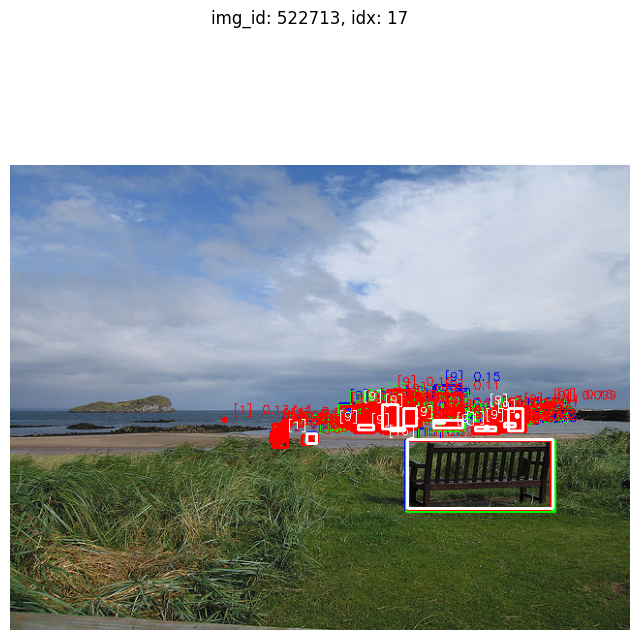

18


In [133]:
img_id = img_ids[img_idx]

data_path = Path("./data/coco/images/val2017")
imgs = coco_gt.loadImgs([img_id])
img_path = data_path/imgs[0]["file_name"]

img = cv2.imread(str(img_path))

for idx in range(3):
    dt_color = dt_colors[idx]
    coco_dt = coco_dts[idx]

    for ann in coco_dt.imgToAnns[img_id]:
        box_x = int(ann["bbox"][0])
        box_y = int(ann["bbox"][1])
        box_w = int(ann["bbox"][2])
        box_h = int(ann["bbox"][3])
        cv2.rectangle(
            img=img,
            pt1=(box_x, box_y), # top left corner
            pt2=(box_x+box_w, box_y+box_h), # bottom right corner
            color=dt_color,
            thickness=2
        )
        cv2.putText(img, f"[{ann['category_id']}]", (box_x+10, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, dt_color, 1)
        cv2.putText(img, f"{(ann['score']):.2}", (box_x+40, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, dt_color, 1)

for ann in coco_gt.imgToAnns[img_id]:
    box_x = int(ann["bbox"][0])
    box_y = int(ann["bbox"][1])
    box_w = int(ann["bbox"][2])
    box_h = int(ann["bbox"][3])
    cv2.rectangle(
        img=img,
        pt1=(box_x, box_y), # top left corner
        pt2=(box_x+box_w, box_y+box_h), # bottom right corner
        color=gt_color,
        thickness=2
    )
    cv2.putText(img, f"[{ann['category_id']}]", (box_x-20, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, gt_color, 1)

plt.figure(figsize=(8,8))
plt.suptitle(f"img_id: {img_id}, idx: {img_idx}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
img_idx += 1
print(img_idx)

In [155]:
def box_area(bbox):
    return bbox[2] * bbox[3]

def intersection_over_union(bbox1, bbox2):
    epsilon = 1e-6
    area1 = box_area(bbox1)
    area2 = box_area(bbox2)

    # intersection
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y2 = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])

    inter_area = max(0, x2-x1) * max(0, y2-y1)
    return inter_area / float(area1 + area2 - inter_area)

def mean_average_precision(anns_dt, anns_gt, cat_ids, iou_thr=0.5):
    precisions = []
    epsilon = 1e-6
    for cat in cat_ids:
        dts = []
        gts = []

        for ann in anns_dt:
            if ann["category_id"] == cat:
                dts.append([ann["score"], ann["bbox"]])

        for ann in anns_gt:
            if ann["category_id"] == cat:
                gts.append(ann["bbox"])

        if len(dts) == len(gts) == 0:
            continue

        dts.sort() # by score
        tps = [0 for _ in range(len(dts))] # true positives
        fps = [0 for _ in range(len(dts))] # false positives
        used_gt = [False for _ in range(len(gts))] # check gt is used

        for idx_dt, (score, dt) in enumerate(dts):
            best_iou = 0.
            best_iou_idx = None

            for idx_gt, gt in enumerate(gts):
                iou = intersection_over_union(dt, gt)

                if iou > best_iou:
                    best_iou = iou
                    best_iou_idx = idx_gt

            if best_iou > iou_thr:
                if tps[idx_dt] == 0 and (not used_gt[best_iou_idx]):
                    tps[idx_dt] = 1
                    used_gt[best_iou_idx] = True
                else:
                    fps[idx_dt] = 1
            else:
                fps[idx_dt] = 1

        precisions.append(sum(tps) / (sum(tps) + sum(fps) + epsilon))

    return sum(precisions)/ (len(precisions) + epsilon)

def mAP_50_95(anns_dt, anns_gt, cat_ids):
    precisions = []
    epsilon = 1e-6
    for i in range(10):
        iou_thr = 0.5 + i * 0.05
        precisions.append(mean_average_precision(anns_dt, anns_gt, cat_ids, iou_thr))
    return sum(precisions)/(len(precisions) + epsilon)

anns_dt = coco_dt.imgToAnns[img_id]
anns_gt = coco_gt.imgToAnns[img_id]
cat_ids = coco_gt.getCatIds()
print(mAP_50_95(anns_dt, anns_gt, cat_ids))

0.0


In [156]:
data = {}
img_ids = coco_gt.getImgIds()
cat_ids = coco_gt.getCatIds()

for idx, coco_dt in enumerate(coco_dts):
    dt_name = dt_names[idx]
    data[dt_name] = []
    print(f"processing {dt_name}...")
    
    for img_id in tqdm(img_ids):
        anns_dt = coco_dt.imgToAnns[img_id]
        anns_gt = coco_gt.imgToAnns[img_id]
        data[dt_name].append(mAP_50_95(anns_dt, anns_gt, cat_ids))

processing faster_rcnn_R_50_C4...


100%|██████████| 5000/5000 [00:12<00:00, 391.73it/s]


processing faster_rcnn_R_50_DC5...


100%|██████████| 5000/5000 [00:13<00:00, 371.86it/s]


processing retinanet_R_50_FPN...


100%|██████████| 5000/5000 [00:22<00:00, 223.65it/s]


In [161]:
df = pd.DataFrame.from_dict(data)
print(df.describe())

fig = df.plot()
fig.show()


       faster_rcnn_R_50_C4  faster_rcnn_R_50_DC5  retinanet_R_50_FPN
count          5000.000000           5000.000000         5000.000000
mean              0.104220              0.125520            0.030147
std               0.116848              0.142318            0.037989
min               0.000000              0.000000            0.000000
25%               0.037500              0.043333            0.007853
50%               0.070512              0.083333            0.016781
75%               0.125000              0.150000            0.037055
max               0.999998              0.999998            0.448453


cnt: 1
cnt: 12


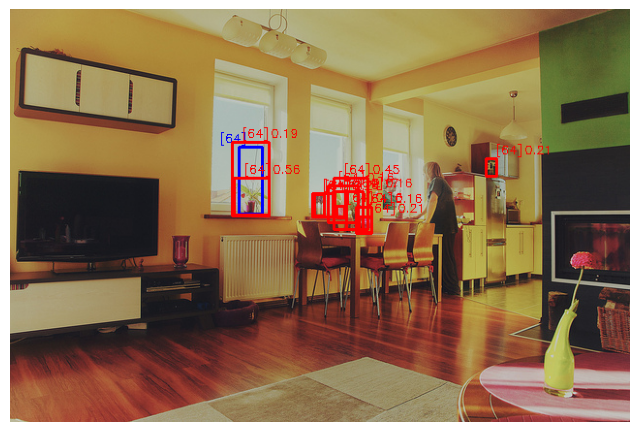

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [93]:
img_id = 139
data_path = Path("./data/coco/images/val2017")
images = coco_gt.loadImgs([img_id])
image_path = data_path/images[0]["file_name"]

img = cv2.imread(str(image_path))
gt_color = (255, 0, 0)
filter_cat = 64

cnt = 0
for ann in coco_gt.imgToAnns[img_id]:
    if ann["category_id"] != filter_cat:
        continue
    box_x = int(ann["bbox"][0])
    box_y = int(ann["bbox"][1])
    box_w = int(ann["bbox"][2])
    box_h = int(ann["bbox"][3])
    cv2.rectangle(
        img=img,
        pt1=(box_x, box_y), # top left corner
        pt2=(box_x+box_w, box_y+box_h), # bottom right corner
        color=gt_color,
        thickness=2
    )
    cv2.putText(img, f"[{ann['category_id']}]", (box_x-20, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, gt_color, 1)
    cnt += 1
print(f"cnt: {cnt}")

dt_color = (0, 0, 255)
cnt = 0
for ann in coco_dt.imgToAnns[img_id]:
    if ann["category_id"] != filter_cat:
        continue
    box_x = int(ann["bbox"][0])
    box_y = int(ann["bbox"][1])
    box_w = int(ann["bbox"][2])
    box_h = int(ann["bbox"][3])
    cv2.rectangle(
        img=img,
        pt1=(box_x, box_y), # top left corner
        pt2=(box_x+box_w, box_y+box_h), # bottom right corner
        color=dt_color,
        thickness=2
    )
    cv2.putText(img, f"[{ann['category_id']}]", (box_x+10, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, dt_color, 1)
    cv2.putText(img, f"{(ann['score']):.2}", (box_x+40, box_y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, dt_color, 1)

    cnt += 1
print(f"cnt: {cnt}")


plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


true_pos = {cat_id: 0 for cat_id in cat_ids}
false_pos = {cat_id: 0 for cat_id in cat_ids}

m_ap = 0
cnt = 0
for cat_id in cat_ids:
    ious = coco_eval.ious[(img_id, cat_id)]
    if isinstance(ious, list) and len(ious) == 0:
        continue
    
    print(type(ious))
    ap = 0
    for i in range(10):
            iou_thr = 0.5 + i * 0.05


        
    m_ap += ap     
    cnt += 1



In [97]:
img_id = 139
cat_id = 64
ious = coco_eval.ious[img_id, cat_id]
scores = []
for ann in coco_dt.imgToAnns[img_id]:
    if ann["category_id"] == cat_id:
        scores = ann["score"]

[{'image_id': 139,
  'category_id': 62,
  'bbox': [294.19781494140625,
   219.4418487548828,
   60.5628662109375,
   98.65303039550781],
  'score': 0.8355884552001953,
  'segmentation': [[294.19781494140625,
    219.4418487548828,
    294.19781494140625,
    318.0948791503906,
    354.76068115234375,
    318.0948791503906,
    354.76068115234375,
    219.4418487548828]],
  'area': 5974.71028114669,
  'id': 92327,
  'iscrowd': 0},
 {'image_id': 139,
  'category_id': 72,
  'bbox': [4.080763816833496,
   165.3658905029297,
   151.74220275878906,
   101.47596740722656],
  'score': 0.82149338722229,
  'segmentation': [[4.080763816833496,
    165.3658905029297,
    4.080763816833496,
    266.84185791015625,
    155.82296657562256,
    266.84185791015625,
    155.82296657562256,
    165.3658905029297]],
  'area': 15398.186821451643,
  'id': 92328,
  'iscrowd': 0},
 {'image_id': 139,
  'category_id': 62,
  'bbox': [365.358642578125,
   218.8936767578125,
   76.15548706054688,
   99.92770385742

In [ ]:
ensemble_sum = []
img_ids = coco_gt.getImgIds()
for img_id in img_ids:
    for coco_dt in coco_dts:
        for ann in coco_dt.imgToAnns[img_id]:
            ensemble_sum.append(ann)
# Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273

In [ ]:
ensemble = []

iou_thr = 0.3 # Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
iou_thr = 0.5 # Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
iou_thr = 0.7 # Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370

for img_id in img_ids:
    tmp_anns = []
    for ann in coco_dts[2].imgToAnns[img_id]:
        tmp_anns.append([0, ann])
    
    for ann in coco_dts[0].imgToAnns[img_id]:
        for tmp_ann in tmp_anns:
            if iou_thr < intersection_over_union(tmp_ann[1]["bbox"], ann["bbox"]):
                tmp_ann[0] += 1

    for ann in coco_dts[1].imgToAnns[img_id]:
        for tmp_ann in tmp_anns:
            if iou_thr < intersection_over_union(tmp_ann[1]["bbox"], ann["bbox"]):
                tmp_ann[0] += 1

    for tmp_ann in tmp_anns:
        if tmp_ann[0] > 0:
            ensemble.append(tmp_ann[1])

In [175]:
print(ann)
coco_gt.loadImgs(img_id)
height = coco_gt.loadImgs(img_id)[0]["height"]
print(height)
width = coco_gt.loadImgs(img_id)[0]["width"]
print(width)

{'image_id': 15335, 'category_id': 60, 'bbox': [34.50001907348633, 392.03948974609375, 71.59129333496094, 39.518463134765625], 'score': 0.05100828409194946, 'segmentation': [[34.50001907348633, 392.03948974609375, 34.50001907348633, 431.5579528808594, 106.09131240844727, 431.5579528808594, 106.09131240844727, 392.03948974609375]], 'area': 2829.177886427846, 'id': 838364, 'iscrowd': 0}
480
640


In [178]:
import ensemble_boxes

ensemble = []

iou_thr = 0.5
skip_box_thr = 0.0001
cnt_id = 0
for img_id in img_ids:
    height = float(coco_gt.loadImgs(img_id)[0]["height"])
    width = float(coco_gt.loadImgs(img_id)[0]["width"])

    tmp_anns = []
    boxes_list = []
    scores_list = []
    labels_list = []

    for coco_dt in coco_dts:
        boxes = []
        scores = []
        labels = []
        for ann in coco_dt.imgToAnns[img_id]:
            x1, y1 = ann["bbox"][0], ann["bbox"][1]
            x2 = ann["bbox"][0] + ann["bbox"][2]
            y2 = ann["bbox"][1] + ann["bbox"][3]
            x1, x2 = x1/width, x2/width
            y1, y2 = y1/height, y2/height
            boxes.append([x1,y1,x2,y2])
            scores.append(ann["score"])
            labels.append(ann["category_id"])

        boxes_list.append(boxes)
        scores_list.append(scores)
        labels_list.append(labels)
    
    boxes, scores, labels = ensemble_boxes.weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        
        x1 *= width
        x2 *= width
        y1 *= height
        y2 *= height

        ann = dict(
            image_id=img_id,
            category_id=label,
            bbox=[x1, y1, x2-x1, y2-y1],
            score=score,
            id=cnt_id,
        )
        cnt_id += 1

        ensemble.append(ann)

coco_ensemble = coco_gt.loadRes(ensemble)
coco_eval = COCOeval(coco_gt, coco_ensemble, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

/home/kyungpyo/git/Ensemble-Object-Detection-using-Detectron2/env/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning:

Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.

/home/kyungpyo/git/Ensemble-Object-Detection-using-Detectron2/env/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning:

X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.



Loading and preparing results...
DONE (t=2.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=32.00s).
Accumulating evaluation results...
DONE (t=6.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [164]:
coco_eval = COCOeval(coco_gt, coco_gt.loadRes("./retinanet_R_50_FPN_1x.yaml/coco_instances_results.json"), "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...
DONE (t=3.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=30.62s).
Accumulating evaluation results...
DONE (t=5.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1